In [1]:
import sys
sys.path.append('/mnt/pfs/akash.mishra/ppe_model/')
import numpy as np
import matplotlib.pyplot as plt
import waveform_model
# import pycbc.ppe.ppe_tools as ppe_tools

import pycbc
import bilby
import numpy as np
import matplotlib.pylab as plt
import pycbc.psd
from waveform_model import ppe_c1_eps_model_rescaled
np.set_printoptions(threshold=sys.maxsize)
import pycbc.waveform as wf
from prior import DiscreteUniform

Version 1.1


In [2]:
pip show bilby

Name: bilby
Version: 1.1.5
Summary: A user-friendly Bayesian inference library
Home-page: https://git.ligo.org/lscsoft/bilby
Author: Greg Ashton, Moritz Huebner, Paul Lasky, Colm Talbot
Author-email: paul.lasky@monash.edu
License: MIT
Location: /home/akash.mishra/miniconda3/envs/igwn-py38_td/lib/python3.8/site-packages
Requires: astropy, attrs, corner, dill, dynesty, emcee, h5py, matplotlib, mock, numpy, pandas, scipy, tables, tqdm
Required-by: bilby-pipe, cwinpy, gwpopulation
Note: you may need to restart the kernel to use updated packages.


In [2]:
frequency_array = np.arange(20, 1024, 1/4)
mass_2 = 32
mass_1 = 35
luminosity_distance = 400
theta_jn = 0.5
phase = 0.5
b = -1
rescaled_beta = 0.5
rescaled_eps = 0.1

hp = ppe_c1_eps_model_rescaled(frequency_array, mass_1, mass_2, 0.5, 0.5, 0.0, 0.0, 
                               luminosity_distance, theta_jn, 0.0, 0.0, phase, b, rescaled_beta, rescaled_eps, a=0.0, alpha=0.0)['cross']

hc = ppe_c1_eps_model_rescaled(frequency_array, mass_1, mass_2, 0.5, 0.5, 0.0, 0.0, 
                               luminosity_distance, theta_jn, 0.0, 0.0, phase, b, rescaled_beta, rescaled_eps, a=0.0, alpha=0.0)['cross']




# MisMatch Analysis

In [3]:
# PSD

delta_f = 1/8
fhigh = 1024
flen = int(fhigh/delta_f) + 1
flow = 20

asd_file_HL='/mnt/pfs/akash.mishra/ppe_model/Noise/aLIGO_O4_high_asd.txt'
psd_HL = pycbc.psd.from_txt(asd_file_HL, flen, delta_f,flow, is_asd_file=True)

psd_file_V='/mnt/pfs/akash.mishra/ppe_model/Noise/AdV_psd.txt'
psd_V = pycbc.psd.from_txt(psd_file_V, flen, delta_f,flow, is_asd_file=False)

In [4]:
waveform_arguments = dict(waveform_approximant='IMRPhenomPv2',reference_frequency=20., minimum_frequency=20.)
sampling_frequency=2048
duration=8
waveform_generator_gr = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,parameter_conversion = bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,waveform_arguments=waveform_arguments)

19:33 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [5]:
waveform_generator_ppe = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=ppe_c1_eps_model_rescaled,parameter_conversion = bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,waveform_arguments=waveform_arguments)

19:33 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: waveform_model.ppe_c1_eps_model_rescaled
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [6]:
inj_pars_gr=dict(mass_1 = 35, mass_2 = 30, a_1 = 0.5, a_2 = 0.4, tilt_1 = 3.1, tilt_2 = 2.9, luminosity_distance = 558.553, theta_jn = 2.921, phi_12 = 0.0, phi_jl = 0.0, 
                phase = 1.893, ra = 1.9, dec = -1.22, psi = 0.8, geocent_time = 1126259462.414)
hp = waveform_generator_gr.frequency_domain_strain(inj_pars_gr)['plus']
hc = waveform_generator_gr.frequency_domain_strain(inj_pars_gr)['cross']

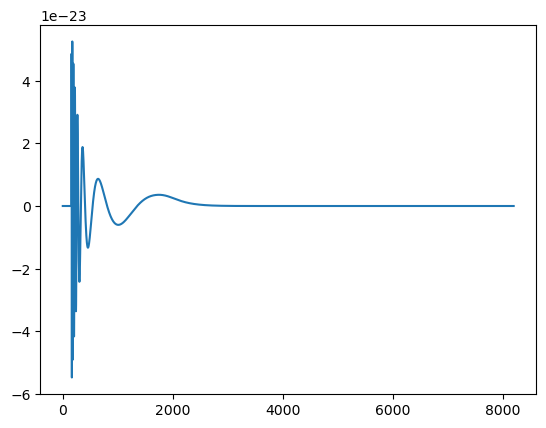

In [7]:
plt.plot(hp)

# Test

In [8]:
inj_pars_gr=dict(mass_1 = 35, mass_2 = 30, a_1 = 0.5, a_2 = 0.4, tilt_1 = 3.1, tilt_2 = 2.9, luminosity_distance = 558.553, theta_jn = 2.921, phi_12 = 0.0, phi_jl = 0.0, 
                phase = 1.893, ra = 1.9, dec = -1.22, psi = 0.8, geocent_time = 1126259462.414)

inj_pars_ppe = dict(mass_1 = 35, mass_2 = 30, a_1 = 0.5, a_2 = 0.4, tilt_1 = 3.1, tilt_2 = 2.9, luminosity_distance = 558.553, theta_jn = 2.921, phi_12 = 0.0, phi_jl = 0.0, 
                phase = 1.893, ra = 1.9, dec = -1.22, psi = 0.8, geocent_time = 1126259462.414, rescaled_beta = 0.3,
                   rescaled_eps = 0.1, b = -1, alpha = 0.0, a = 0.0)

In [9]:
ifos1 = bilby.gw.detector.InterferometerList(['H1'])
ifos2 = bilby.gw.detector.InterferometerList(['H1'])

ifos1.set_strain_data_from_zero_noise(sampling_frequency=sampling_frequency, duration=duration,
               start_time=inj_pars_gr['geocent_time'] - 6)
        
ifos2.set_strain_data_from_zero_noise(sampling_frequency=sampling_frequency, duration=duration,\
                                          start_time=inj_pars_ppe['geocent_time'] - 6)

In [10]:
match_H1, shift_H1 = ts_1_H1.match(ts_2_H1,psd=psd_HL,low_frequency_cutoff=flow,high_frequency_cutoff=fhigh)

NameError: name 'ts_1_H1' is not defined

In [11]:
match_H1

NameError: name 'match_H1' is not defined

In [12]:
gr_pols = waveform_generator_gr.frequency_domain_strain(parameters=inj_pars_gr)
hp_gr = gr_pols['plus']

In [13]:
frequency_series_gr = pycbc.types.FrequencySeries(hp_gr, delta_f=delta_f)
def MatchCalculator(rescaled_beta, rescaled_eps, b):
    inj_pars_ppe = dict(mass_1 = 35, mass_2 = 30, a_1 = 0.5, a_2 = 0.4, tilt_1 = 3.1, tilt_2 = 2.9, luminosity_distance = 558.553, theta_jn = 2.921, phi_12 = 0.0, phi_jl = 0.0, 
                phase = 1.893, ra = 1.9, dec = -1.22, psi = 0.8, geocent_time = 1126259462.414, rescaled_beta = rescaled_beta,
                   rescaled_eps = rescaled_eps, b = b, alpha = 0.0, a = 0.0)
    
    ppe_pols = waveform_generator_ppe.frequency_domain_strain(parameters=inj_pars_ppe)
    hp_ppe = ppe_pols['plus']
    frequency_series_ppe = pycbc.types.FrequencySeries(hp_ppe, delta_f=delta_f)
    
    match_H1, shift_H1 = frequency_series_gr.match(frequency_series_ppe,psd=psd_HL,low_frequency_cutoff=flow,high_frequency_cutoff=fhigh)
    
    return match_H1

In [47]:
MatchCalculator(3, 0.2, -1)

0.7951510465395464

In [20]:
import numpy as np
import matplotlib.pyplot as plt
n_points = 10000
b_value = -1
# Create the grid using linspace for both x and y
rescaled_beta = np.linspace(-10.0, 10.0, 100)
rescaled_eps = np.linspace(-10.0, 10.0, 100)

# Generate all combinations of x and y
rescaled_beta_grid, rescaled_eps_grid = np.meshgrid(rescaled_beta, rescaled_eps)
beta_tuples = rescaled_beta_grid.flatten()
eps_tuples = rescaled_eps_grid.flatten()

# Generate 100 random tuples (x, y)
random_indices = np.random.choice(len(beta_tuples), n_points, replace=True)
random_beta = beta_tuples[random_indices]
random_eps = eps_tuples[random_indices]

# Calculate f(x, y) = exp(-x^2 + y^2)
Match_values = []
for i in range(n_points):
    Match_values.append(MatchCalculator(random_beta[i], random_eps[i], b_value))

# Create the density plot using plt.scatter


In [6]:
from functions import *
beta_from_beta_tilde_wrapped(-0.3, 20, 0.3, -4, 0.018, 70)

-0.012551042500482936

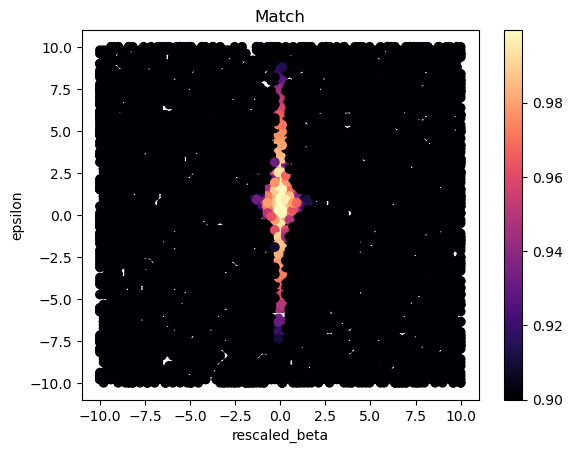

In [19]:
plt.scatter(random_beta, random_eps, c=Match_values, cmap='magma', vmin = 0.9)

# Add a colorbar to show the colormap scale
plt.colorbar()

# Add labels and title to the plot (optional)
plt.xlabel('rescaled_beta')
plt.ylabel('epsilon')
plt.title('Match')
plt.savefig('b_3.pdf')
# Show the plot
plt.show()

In [84]:
ifos1.set_strain_data_from_zero_noise(sampling_frequency=sampling_frequency, duration=duration,
               start_time=inj_pars_gr['geocent_time'] - 6)

In [29]:
def calc_mismatch_injections(inj_pars1,inj_pars2, waveform_generator_gr, waveform_generator_ppe, psd_H, sampling_frequency=2048,duration=8,flow=20,fhigh=1024):
    """Calculate mismatch between the strains two sets of injection parameters, waveform generator and PSDs."""
    
    ifos1 = bilby.gw.detector.InterferometerList(['H1'])
    ifos2 = bilby.gw.detector.InterferometerList(['H1'])
    
    

    ifos1.set_strain_data_from_zero_noise(sampling_frequency=sampling_frequency, duration=duration,
               start_time=inj_pars1['geocent_time'] - 6)
        
    ifos2.set_strain_data_from_zero_noise(sampling_frequency=sampling_frequency, duration=duration,\
                                          start_time=inj_pars2['geocent_time'] - 6)

    inj1 = ifos1.inject_signal(waveform_generator=waveform_generator_gr,parameters=inj_pars1)
    inj2 = ifos2.inject_signal(waveform_generator=waveform_generator_ppe,parameters=inj_pars2)
    fs_1_H1 = ifos1[0].strain_data.to_pycbc_frequencyseries()

    fs_2_H1 = ifos2[0].strain_data.to_pycbc_frequencyseries()

    match_H1, shift_H1 = fs_1_H1.match(fs_2_H1,psd=psd_H,low_frequency_cutoff=flow,high_frequency_cutoff=fhigh)
#     match_L1, shift_L1 = fs_1_L1.match(fs_2_L1,psd=psd_L,low_frequency_cutoff=flow,high_frequency_cutoff=fhigh)
#     match_V1, shift_V1 = fs_1_V1.match(fs_2_V1,psd=psd_V,low_frequency_cutoff=flow,high_frequency_cutoff=fhigh)
    return np.array([1-match_H1]), np.array([shift_H1]),np.array([ifos1,ifos2])

In [30]:
def plot_mismatch_beta_e_grid(rescaled_beta_grid,rescaled_eps_grid,b, mismatchs_arr,save=False):
    plt.figure(figsize=(6,5))
    c= mismatchs_arr#np.log((mismatchs_arr**2).sum(axis=2).flatten())
    plt.scatter(rescaled_beta_grid.flatten(),rescaled_eps_grid.flatten(),c=c, cmap = 'magma')
    print(c)
    plt.xlabel('beta')
    plt.ylabel('e')
    plt.clim(-6,0)
    plt.grid()
    plt.xlim(-3,3)
    plt.ylim(-3, 3)
    plt.colorbar()
    ax=plt.gca()
    #ax.set_yticks(np.arange(0, np.pi/2+0.01, np.pi/8))
    #labels = ['$0$', r'$\pi/8$', r'$\pi/4$', r'$3\pi/8$', r'$\pi/2$']
    #ax.set_yticklabels(labels)
    if save == True:
        plt.savefig('mismatch_plots/'+save +str(b)+'.pdf')
    plt.title('Match ppe and GR waveform b = '+str(b))
    plt.show()

In [35]:
def mismatch_beta_e_grid(inj_pars1, inj_pars2, rescaled_beta_grid, rescaled_eps_grid, b, plot=False,save=False):
    """ Returns mismatch and shifts 3D arrays nbeta x ne x ndets"""
    mismatchs_arr = np.zeros([rescaled_beta_grid.shape[0],rescaled_eps_grid.shape[1],3])
    shifts_arr = np.zeros([rescaled_beta_grid.shape[0],rescaled_eps_grid.shape[1],3])
    
    inj_pars2['b'] = b
    
    for i in range(rescaled_beta_grid.shape[0]):
        for j in range(rescaled_beta_grid.shape[1]):
            inj_pars2['rescaled_beta'] = rescaled_beta_grid[i,j]
            inj_pars2['rescaled_eps']=rescaled_eps_grid[i,j]
            mismatchs,shifts,ifos = calc_mismatch_injections(inj_pars_gr, inj_pars2, waveform_generator_gr, waveform_generator_ppe, psd_HL)
            mismatchs_arr[i,j,:],shifts_arr[i,j,:] =  mismatchs,shifts
            #print('mismatch for (i,j) -> (', i, j, ') i.e. (',beta_grid[i,j], e_grid[i,j], ' is ', mismatchs)
    if save == True:
         np.savez('mismatch_plots/'+save+str(b)+'.npz', rescaled_beta_grid=rescaled_beta_grid,rescaled_eps_grid=rescaled_eps_grid,mismatchs_arr=mismatchs_arr,shifts_arr=shifts_arr)
    #print(mismatchs_arr)
    if plot == True:
        plot_mismatch_beta_e_grid(rescaled_beta_grid,rescaled_eps_grid,b,mismatchs_arr,save=save)
    return mismatchs_arr,shifts_arr

In [39]:
 inj_pars_gr

{'mass_1': 35,
 'mass_2': 30,
 'a_1': 0.5,
 'a_2': 0.4,
 'tilt_1': 3.1,
 'tilt_2': 2.9,
 'luminosity_distance': 558.553,
 'theta_jn': 2.921,
 'phi_12': 0.0,
 'phi_jl': 0.0,
 'phase': 1.893,
 'ra': 1.9,
 'dec': -1.22,
 'psi': 0.8,
 'geocent_time': 1126259462.414,
 'b': -1,
 'rescaled_beta': -3.0,
 'rescaled_eps': -3.0}

In [40]:
calc_mismatch_injections(inj_pars_gr, inj_pars_ppe, waveform_generator_gr, waveform_generator_ppe, psd_HL)

17:40 bilby INFO    : Injected signal in H1:
17:40 bilby INFO    :   optimal SNR = 43.26
17:40 bilby INFO    :   matched filter SNR = 43.26+0.00j
17:40 bilby INFO    :   mass_1 = 35
17:40 bilby INFO    :   mass_2 = 30
17:40 bilby INFO    :   a_1 = 0.5
17:40 bilby INFO    :   a_2 = 0.4
17:40 bilby INFO    :   tilt_1 = 3.1
17:40 bilby INFO    :   tilt_2 = 2.9
17:40 bilby INFO    :   luminosity_distance = 558.553
17:40 bilby INFO    :   theta_jn = 2.921
17:40 bilby INFO    :   phi_12 = 0.0
17:40 bilby INFO    :   phi_jl = 0.0
17:40 bilby INFO    :   phase = 1.893
17:40 bilby INFO    :   ra = 1.9
17:40 bilby INFO    :   dec = -1.22
17:40 bilby INFO    :   psi = 0.8
17:40 bilby INFO    :   geocent_time = 1126259462.414
17:40 bilby INFO    :   b = -1
17:40 bilby INFO    :   rescaled_beta = -3.0
17:40 bilby INFO    :   rescaled_eps = -3.0
17:40 bilby INFO    : Injected signal in H1:
17:40 bilby INFO    :   optimal SNR = 43.26
17:40 bilby INFO    :   matched filter SNR = 43.26+0.00j
17:40 bilb

(array([0.01145741]),
 array([0]),
 array([[Interferometer(name='H1', power_spectral_density=PowerSpectralDensity(psd_file='None', asd_file='/home/akash.mishra/miniconda3/envs/igwn-py38/lib/python3.8/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt'), minimum_frequency=20.0, maximum_frequency=1024.0, length=4.0, latitude=46.45514666666667, longitude=-119.4076571388889, elevation=142.554, xarm_azimuth=125.9994, yarm_azimuth=215.9994, xarm_tilt=-0.0006195, yarm_tilt=1.25e-05)],
        [Interferometer(name='H1', power_spectral_density=PowerSpectralDensity(psd_file='None', asd_file='/home/akash.mishra/miniconda3/envs/igwn-py38/lib/python3.8/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt'), minimum_frequency=20.0, maximum_frequency=1024.0, length=4.0, latitude=46.45514666666667, longitude=-119.4076571388889, elevation=142.554, xarm_azimuth=125.9994, yarm_azimuth=215.9994, xarm_tilt=-0.0006195, yarm_tilt=1.25e-05)]],
       dtype=object))

In [41]:
inj_pars_gr=dict(mass_1 = 35, mass_2 = 30, a_1 = 0.5, a_2 = 0.4, tilt_1 = 3.1, tilt_2 = 2.9, luminosity_distance = 558.553, theta_jn = 2.921, phi_12 = 0.0, phi_jl = 0.0, 
                phase = 1.893, ra = 1.9, dec = -1.22, psi = 0.8, geocent_time = 1126259462.414)

inj_pars_ppe = dict(mass_1 = 35, mass_2 = 30, a_1 = 0.5, a_2 = 0.4, tilt_1 = 3.1, tilt_2 = 2.9, luminosity_distance = 558.553, theta_jn = 2.921, phi_12 = 0.0, phi_jl = 0.0, 
                phase = 1.893, ra = 1.9, dec = -1.22, psi = 0.8, geocent_time = 1126259462.414, rescaled_beta = 0.3,
                   rescaled_eps = 0.1, b = -1, alpha = 0.0, a = 0.0)
beta = np.linspace(-3.0,3.0,2)

eps = np.linspace(-3.0,3.0, 2)

rescaled_beta_grid, rescaled_eps_grid=np.meshgrid(beta,eps)

mismatchs_arr,shifts_arr = mismatch_beta_e_grid(inj_pars_gr, inj_pars_gr, rescaled_beta_grid, rescaled_eps_grid, -1)

17:40 bilby INFO    : Injected signal in H1:
17:40 bilby INFO    :   optimal SNR = 43.26
17:40 bilby INFO    :   matched filter SNR = 43.26+0.00j
17:40 bilby INFO    :   mass_1 = 35
17:40 bilby INFO    :   mass_2 = 30
17:40 bilby INFO    :   a_1 = 0.5
17:40 bilby INFO    :   a_2 = 0.4
17:40 bilby INFO    :   tilt_1 = 3.1
17:40 bilby INFO    :   tilt_2 = 2.9
17:40 bilby INFO    :   luminosity_distance = 558.553
17:40 bilby INFO    :   theta_jn = 2.921
17:40 bilby INFO    :   phi_12 = 0.0
17:40 bilby INFO    :   phi_jl = 0.0
17:40 bilby INFO    :   phase = 1.893
17:40 bilby INFO    :   ra = 1.9
17:40 bilby INFO    :   dec = -1.22
17:40 bilby INFO    :   psi = 0.8
17:40 bilby INFO    :   geocent_time = 1126259462.414
17:40 bilby INFO    :   b = -1
17:40 bilby INFO    :   rescaled_beta = -3.0
17:40 bilby INFO    :   rescaled_eps = -3.0


KeyError: 'alpha'

In [65]:
mismatchs_arr

array([[[nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan]]])

In [102]:
import bilby
import numpy as np
class DiscreteUniform(bilby.prior.Uniform):

    def __init__(self, minimum, maximum, name=None, latex_label=None,
                 unit=None, boundary=None):
        """Log-Uniform prior with bounds
        Parameters
        ==========
        minimum: int
            See superclass
        maximum: int
            See superclass
        name: str
            See superclass
        latex_label: str
            See superclass
        unit: str
            See superclass
        boundary: str
            See superclass
        """
        if not isinstance(minimum, int) or not isinstance(maximum, int):
            raise ValueError("minimum/maximum must be integers")
            
        super(DiscreteUniform, self).__init__(name=name, latex_label=latex_label, unit=unit,
                                         minimum=minimum, maximum=maximum+1, boundary=boundary)
        
        
    def rescale(self, val):
        """
        'Rescale' a sample from the unit line element to the power-law prior.
        This maps to the inverse CDF. This has been analytically solved for this case.
        Parameters
        ==========
        val: Union[float, int, array_like]
            Uniform probability
        Returns
        =======
        Union[float, array_like]: Rescaled probability
        """
        value = np.floor(self.minimum + val * (self.maximum  - self.minimum))
        value = np.where(value == 0, np.floor(np.random.uniform(low=self.minimum, high=self.maximum, size=1))[0], value)
        
            
        return value

In [103]:
custom_prior = DiscreteUniform(name='billy', latex_label='$billy$', minimum=-6, maximum=3)

# Example usage to sample from the prior
samples = custom_prior.sample(100)

In [106]:
samples

array([-4., -2., -1., -3.,  3.,  1.,  1., -4., -2., -5., -2.,  3.,  1.,
        3., -5.,  3., -4., -3.,  3., -1., -3., -5.,  2.,  2., -3.,  3.,
       -5., -5., -1., -3.,  3., -5.,  3., -1., -1., -2.,  1., -4.,  2.,
       -5., -5.,  1., -6., -4., -4.,  3.,  3., -3., -3., -3., -5., -6.,
       -3., -3.,  2., -5.,  1., -1., -2., -3., -1., -1., -2.,  3., -4.,
       -3., -2.,  1., -3., -3.,  1.,  2., -3., -2., -6., -6., -5.,  2.,
        2., -5.,  3., -3., -3., -6.,  3., -3.,  1., -3.,  1., -4., -5.,
       -4., -4., -3., -3.,  3.,  1., -5., -5.,  3.])

In [98]:
random_number = np.floor(np.random.uniform(low=-7, high=7, size=1))
random_number[0]

-1.0

In [3]:
from prior import DiscreteUniform

In [4]:
import sys
sys.path.append('/mnt/pfs/akash.mishra/ppe_model/')
import numpy as np
import matplotlib.pyplot as plt
import waveform_model
# import pycbc.ppe.ppe_tools as ppe_tools

import pycbc
import bilby
import numpy as np
import matplotlib.pylab as plt
import pycbc.psd
from waveform_model import ppe_c1_eps_model_rescaled
np.set_printoptions(threshold=sys.maxsize)
import pycbc.waveform as wf
from prior import DiscreteUniform
import bilby
from gwpy.timeseries import TimeSeries

logger = bilby.core.utils.logger
outdir = "results"
label = "ppe_inj"
bilby.core.utils.setup_logger(outdir=outdir, label=label)




In [5]:

# Set up a random seed for result reproducibility.  This is optional!
np.random.seed(88170235)

duration = 4.0
sampling_frequency = 1024


injection_parameters = dict(
    mass_1=36.0,
    mass_2=29.0,
    a_1=0.4,
    a_2=0.3,
    tilt_1=0.5,
    tilt_2=1.0,
    phi_12=1.7,
    phi_jl=0.3,
    luminosity_distance=450.0,
    theta_jn=0.4,
    psi=2.659,
    phase=1.3,
    geocent_time=1126259642.413,
    ra=1.375,
    dec=-1.2108,
    a = 0.0,
    alpha = 0.0,
    b = -2,
    rescaled_beta = 1.3,
    rescaled_eps = -0.5,
)

waveform_arguments = dict(
    waveform_approximant="IMRPhenomXPHM",
    reference_frequency=50.0,
    minimum_frequency=20.0,
)

# Create the waveform_generator using a LAL BinaryBlackHole source function
# the generator will convert all the parameters
waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model=ppe_c1_eps_model_rescaled,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments,
)

ifos = bilby.gw.detector.InterferometerList(["H1", "L1"])
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency,
    duration=duration,
    start_time=injection_parameters["geocent_time"] - 2,
)

ifos.inject_signal(
    waveform_generator=waveform_generator, parameters=injection_parameters
)

00:34 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: waveform_model.ppe_c1_eps_model_rescaled
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
00:34 bilby INFO    : Injected signal in H1:
00:34 bilby INFO    :   optimal SNR = 52.35
00:34 bilby INFO    :   matched filter SNR = 50.83-0.03j
00:34 bilby INFO    :   mass_1 = 36.0
00:34 bilby INFO    :   mass_2 = 29.0
00:34 bilby INFO    :   a_1 = 0.4
00:34 bilby INFO    :   a_2 = 0.3
00:34 bilby INFO    :   tilt_1 = 0.5
00:34 bilby INFO    :   tilt_2 = 1.0
00:34 bilby INFO    :   phi_12 = 1.7
00:34 bilby INFO    :   phi_jl = 0.3
00:34 bilby INFO    :   luminosity_distance = 450.0
00:34 bilby INFO    :   theta_jn = 0.4
00:34 bilby INFO    :   psi = 2.659
00:34 bilby INFO    :   phase = 1.3
00:34 bilby INFO    :   geocent_time = 1126259642.413
00:34 bilby INFO    :   ra = 1.375
00:34 bilby INFO    :   dec = -1.2108
00:34 bilby INFO    :

[{'plus': array([ 0.00000000e+00+0.00000000e+00j,
         -0.00000000e+00+0.00000000e+00j,
          0.00000000e+00-0.00000000e+00j, ...,
          1.22436076e-27+2.82397881e-27j,
          1.20647944e-27+2.80866600e-27j,
          0.00000000e+00+0.00000000e+00j]),
  'cross': array([0.00000000e+00+0.00000000e+00j,
         0.00000000e+00-0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j, ...,
         2.81366583e-27-1.23433195e-27j,
         2.79845735e-27-1.21641548e-27j,
         0.00000000e+00+0.00000000e+00j])},
 {'plus': array([ 0.00000000e+00+0.00000000e+00j,
         -0.00000000e+00+0.00000000e+00j,
          0.00000000e+00-0.00000000e+00j, ...,
          1.22436076e-27+2.82397881e-27j,
          1.20647944e-27+2.80866600e-27j,
          0.00000000e+00+0.00000000e+00j]),
  'cross': array([0.00000000e+00+0.00000000e+00j,
         0.00000000e+00-0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j, ...,
         2.81366583e-27-1.23433195e-27j,
         2.79845735e-27-1

In [6]:
priors = bilby.gw.prior.BBHPriorDict()
priors["geocent_time"] = bilby.core.prior.Uniform(
    minimum=injection_parameters["geocent_time"] - 0.1,
    maximum=injection_parameters["geocent_time"] + 0.1,
    name="geocent_time",
    latex_label="$t_c$",
    unit="$s$",
)
priors['mass_1'].maximum = 70
priors['mass_2'].maximum = 70
priors['luminosity_distance'].maximum = 1000
priors['luminosity_distance'].minimum = 100

priors['alpha'] = 0.0
priors['a'] = 0.0
priors['b']=DiscreteUniform(-7,4,name='b', latex_label='$b$')
### ppe recovery
#priors['b']=DiscreteUniform(-7,1,name='b', latex_label='$b$')
priors['rescaled_beta']=bilby.prior.Uniform(-5.0,5.0,name='beta', latex_label='$\beta$')
priors['rescaled_eps']=bilby.prior.Uniform(-5.0,5.0,name='delta_eps', latex_label='$\delta$')

00:34 bilby INFO    : No prior given, using default BBH priors in /home/akash.mishra/miniconda3/envs/igwn-py38_td/lib/python3.8/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


In [ ]:
likelihood = bilby.gw.GravitationalWaveTransient(
    interferometers=ifos,
    waveform_generator=waveform_generator,
    priors=priors,
    distance_marginalization=False,
    phase_marginalization=False,
    time_marginalization=False,

)

result = bilby.run_sampler(
    likelihood=likelihood,
    priors=priors,
    sampler="dynesty",
    nlive=1500,
    sample = 'unif',
    injection_parameters=injection_parameters,
    outdir=outdir,
    label=label,

    
)

00:34 bilby INFO    : Running for label 'ppe_inj', output will be saved to 'results'
00:34 bilby INFO    : Using lal version 7.3.1
00:34 bilby INFO    : Using lal git version Branch: None;Tag: lal-v7.3.1;Id: ba834368942ae59461ae5154fcf542c4d5a3b5b2;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
00:34 bilby INFO    : Using lalsimulation version 5.2.0
00:34 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsimulation-v5.2.0;Id: 6d939723e10b22ed8775552be67ae1e2004ec9e6;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
00:34 bilby INFO    : Search parameters:
00:34 bilby INFO    :   mass_ratio = Uniform(minimum=0.125, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None)
00:34 bilby INFO    :   chirp_mass = Uniform(minimum=25, maximum=100, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None)
00:34 bilby INFO    :   luminosity_dis

0it [00:00, ?it/s]

00:34 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'unif', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 1800, 'nlive': 1500, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 900, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7fc14a81cd30>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5, 'print_method': 'tqdm'}
00:34 bilby INFO    : Checkpoint every check_point_delta_t = 600s
00:34 bilby INFO    : Using dynesty version 1.0.1
00:34 bilby INFO    : Reading resum

In [16]:
import pickle

# Specify the path to your .pickle file
file_path = '/mnt/pfs/akash.mishra/ppe_model/job_files/injection_studies/rescaled_parameters/b_2_beta13_eps_05/results/ppe_inj_resume.pickle'

# Open and read the .pickle file
with open(file_path, 'rb') as file:
    data = pickle.load(file)

# Process or use the data as needed
print(data)


In [17]:
dres = data.results

In [23]:
from dynesty import plotting as dyplot
dyplot.runplot(dres)
plt.tight_layout()

LinAlgError: singular matrix

In [3]:
import bilby
import numpy as np
class DiscreteUniform(bilby.prior.Uniform):

    def __init__(self, minimum, maximum, name=None, latex_label=None,
                 unit=None, boundary=None):
        """Log-Uniform prior with bounds
        Parameters
        ==========
        minimum: int
            See superclass
        maximum: int
            See superclass
        name: str
            See superclass
        latex_label: str
            See superclass
        unit: str
            See superclass
        boundary: str
            See superclass
        """
        if not isinstance(minimum, int) or not isinstance(maximum, int):
            raise ValueError("minimum/maximum must be integers")
            
        super(DiscreteUniform, self).__init__(name=name, latex_label=latex_label, unit=unit,
                                         minimum=minimum, maximum=maximum+1, boundary=boundary)
        
        
    def rescale(self, val):
        """
        'Rescale' a sample from the unit line element to the power-law prior.
        This maps to the inverse CDF. This has been analytically solved for this case.
        Parameters
        ==========
        val: Union[float, int, array_like]
            Uniform probability
        Returns
        =======
        Union[float, array_like]: Rescaled probability
        """
        
        
        
        return np.floor(self.minimum + val * (self.maximum  - self.minimum))



In [4]:
custom_prior = DiscreteUniform(minimum=-6, maximum=3, name='billy', latex_label='$billy$')
samples = custom_prior.sample(1000)
print(samples)

[ 3. -6. -5.  1. -3.  2.  3.  1. -4. -2.  1. -3.  3.  3. -2.  3. -3.  1.
 -1.  3. -1. -5.  2.  0. -4. -1.  1. -4. -6.  1.  0.  2.  1. -2. -6.  1.
  3. -3. -2. -6. -5. -1. -2. -5. -1.  1. -4.  3. -6. -1. -1.  0. -5.  1.
 -5. -4. -2. -4.  1. -6. -1. -3. -5.  1. -2.  1.  3.  1. -4.  1.  0. -1.
 -6. -3.  0. -2. -1. -4. -5. -3. -1. -6. -5. -3. -3. -6. -1. -1.  3. -1.
 -4.  2.  0. -2.  3.  2. -4. -2. -3. -5. -3.  2. -6. -6. -3. -5. -4.  0.
 -6. -6. -5.  2. -6. -1. -1. -1. -4. -3. -2.  2. -2. -2.  3.  0. -6.  1.
  3.  0. -3. -3.  0.  1. -6. -3. -2.  0. -3. -6.  1. -3.  0. -5. -4. -1.
 -1. -6.  0. -3. -6. -4.  0.  0.  3.  0.  2.  2.  2.  1. -6.  1. -1.  3.
  1. -1. -6.  3. -5. -6.  3. -1. -4. -2.  3. -4. -2.  2. -3. -3.  2.  1.
  3. -1. -6. -5.  3. -5. -3.  0. -3.  0. -6.  0.  3.  2. -3.  0. -2. -2.
 -5. -3. -5. -5. -3. -6. -6.  0. -4.  1.  3. -3. -3.  0. -1. -4. -4. -6.
 -3.  0.  0. -4. -2.  1.  3. -6.  1. -6. -3.  1.  1.  2. -2. -6. -4.  2.
 -2. -1. -5.  0.  3. -3.  1. -1. -3. -2. -5.  3. -4